In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import root 
import copy as cp

In [2]:
## auxiliary functions
def toVec(ma_coeffs,
          sigmas,
          t,
          ma_q):
    """
    stack all coefficients including ma_coeffs, sigmas into a single dimension vector 
    ma_coeffs:  dim = (ma_q,) 
    sigmas:     dim= (2 x t) 
    result:     dim= (ma_q+2t,) 
    """
    assert ma_coeffs.shape == (ma_q,)
    assert sigmas.shape == (2, t)
    return np.hstack([ma_coeffs.flatten(), sigmas.flatten()])

def toPara(vec,
           t,
           ma_q):
    """
    unstack all coefficients including ma_coeffs and sigmas from a single dimension vector to separate arrays 
    vec:   (ma_q+2t,)
    result[0]: ma_coeffs  dim = (ma_q,) 
    result[1]: sigmas dim= (2 x t)  
    """
    assert len(vec) == 2*t + ma_q
    return vec[:ma_q-1], vec[ma_q:].reshape(2,t)

In [74]:
## class of integrated moving average process, trend/cycle process allowing for serial correlation transitory shocks
class IMAProcess:
    '''
    inputs
    ------
    t: int, number of periods of the series
    process_para: dict, includes 
       - mq_q: size of q for MA(q),q = 0 by default. take 0 or 1 for now
       - ϕ, MA(1) coefficient. if ϕ=0, purely transitory 
       - sigmas:  size of 2 x t, draws of permanent and transitory risks from possibly time-varying volatilities 
       In the case of stochastical volatilities following parameters are used as well
       
       ## ARCH parameters 
       - κ_p: how persistent the innovation to permanent risk is
       - κ_θ: how persistent the innovation to transitory risk is
       - γ_p: size of the innovation to permanent risk
       - γ_θ: size of the innovation to transitory risk 
       
    '''
    def __init__(self,
                 t = 100, ## length of sample period  
                 ma_q = 0, 
                 ϕ = -0.3,
                 κ_p = 0.4,
                 κ_θ = 0.4,
                 γ_p = 0.1,
                 γ_θ = 0.3):
        self.t = t
        self.ma_q = ma_q
        self.ϕ = ϕ
        self.sigmas =  np.ones([2,t])
        self.n_agg = 12  ## corresponding to h in the formular 
        self.init_sigmas = np.array([0.1,0.1])
        self.init_sv = np.array([0.1,0.1])
        
        if ma_q == 0:
            self.ma_coeffs=np.array([1])
        if ma_q == 1:
            self.ma_coeffs=np.array([1,ϕ])
        
        ## stochastic vol paras
        self.κ_p = κ_p
        self.κ_θ = κ_θ
        self.γ_p = γ_p
        self.γ_θ = γ_θ
        
    ## auxiliary function for ma cum sum
    def cumshocks(self,
                  shocks,
                  ma_coeffs):
        cum = []
        for i in range(len(shocks)):
            #print(shocks[i])
            #print(sum([ma_coeffs[back]*shocks[i-back] for back in range(len(ma_coeffs))]))
            cum.append(sum([ma_coeffs[back]*shocks[i-back] for back in range(len(ma_coeffs))]))
        return np.array(cum)         
        
    def SimulateSeries(self,
                       n_sim = 200):
        t = self.t 
        ma_coeffs = self.ma_coeffs
        sigmas = self.sigmas
        np.random.seed(12345)                 
        p_draws = np.multiply(np.random.randn(n_sim*t).reshape([n_sim,t]), 
                              np.tile(sigmas[0,:],[n_sim,1]))  # draw permanent shocks
        np.random.seed(12342)
        t_draws = np.multiply(np.random.randn(n_sim*t).reshape([n_sim,t]), 
                              np.tile(sigmas[1,:],[n_sim,1]))  ## draw one-period transitory shocks
    
        t_draws_cum = np.array( [self.cumshocks(shocks = t_draws[i,:],
                                                ma_coeffs = ma_coeffs) 
                                 for i in range(n_sim)]
                              )
        series = np.cumsum(p_draws,axis = 1) + t_draws_cum 
        self.simulated = series
        return self.simulated 

    def SimulatedMoments(self):
        series = self.simulated 
        
        ## moments of levels 
        varcov = np.cov(series.T) 
        
        ## the first difference 
        diff = np.diff(series,axis=1)
        
        ## moments of first diff
        mean_diff = np.mean(diff,axis = 0)  
        varcov_diff = np.cov(diff.T) 
        
        self.SimMoms = {'MeanDiff':mean_diff,
                       'VarDiff':varcov_diff,
                        'VarDiff_fire':np.nan,
                       'Var':varcov}
        return self.SimMoms
    
    def ComputeGenMoments(self):
        ## parameters 
        t = self.t 
        ϕ = self.ϕ
        sigmas = self.sigmas
        p_sigmas = sigmas[0,:]
        t_sigmas = sigmas[1,:]
        
        ## variances for levels 
        var = np.empty(t)
        for i in range(1,t):
            p_sigmas_cum = np.sum([p_sigmas[k]**2 for k in range(i+1)])
            t_sigmas_cum = t_sigmas[i]**2 + t_sigmas[i-1]**2
            var[i] = p_sigmas_cum + t_sigmas_cum 
        var = var[1:]
        
        ## conditional variances for FIRE
        var_diff_fire =  p_sigmas**2 + t_sigmas**2  ##!!!! this is only true for constant vol or martingale ARCH
        
        ## generalized moments 
        mean_diff = np.zeros(t)[1:] 
        ## varcov_diff is basically the variance covariance of first difference of income of this IMA(q) process
        ## Cov(delta y_t - delta y_{t+k}) forall k for all t
        varcov_diff = np.empty((t,t))
        
        for i in range(2,t):
            # ar0 
            autocovf_this = p_sigmas[i]**2 + t_sigmas[i]**2 + (1-ϕ)**2*t_sigmas[i-1]**2+ϕ**2*t_sigmas[i-2]
            varcov_diff[i,i] = autocovf_this
            
        for i in range(2,t-1):
            ## ar1
            varcov_diff[i,i+1] = (ϕ-1)*t_sigmas[i]**2-ϕ*(ϕ-1)*t_sigmas[i-1]**2
            varcov_diff[i+1,i] = (ϕ-1)*t_sigmas[i-1]**2-ϕ*(ϕ-1)*t_sigmas[i-2]**2          
            
        for i in range(2,t-2):
            ## ar2
            varcov_diff[i,i+2] = -ϕ*t_sigmas[i]**2
            varcov_diff[i+2,i] = -ϕ*t_sigmas[i-2]**2
            
        varcov_diff = varcov_diff[1:,1:]
        
        self.GenMoms = {'MeanDiff':mean_diff,
                        'VarDiff':varcov_diff,
                        'VarDiff_fire':var_diff_fire,
                        'Var':var}
        return self.GenMoms  
    
    def TimeAggregate(self):
        n_agg = self.n_agg
        simulated = self.simulated
        t = self.t
        simulated_agg = 1/n_agg*np.array([np.sum(simulated[:,i-n_agg:i],axis=1) for i in range(n_agg,t+1)]).T
        self.simulated_agg = simulated_agg
        return self.simulated_agg

    def SimulateMomentsAgg(self):
        series_agg = self.simulated_agg 
        n_agg = self.n_agg
        
        ## level 
        varcov = np.cov(series_agg.T) 

        ## the first difference 
        diff = np.diff(series_agg,
                       n = n_agg,
                       axis = 1)
        ## moments of aggregated first diff
        mean_diff = np.mean(diff,axis = 0)
        varcov_diff = np.cov(diff.T)
        
        self.SimAggMoms = {'MeanDiff':mean_diff,
                           'VarDiff':varcov_diff,
                           'Var':varcov}
        return self.SimAggMoms

    def ComputeMomentsAggConsVol(self):
        n_agg = self.n_agg
        sigmas = self.sigmas
        ϕ = self.ϕ
        sigma_ψ = sigmas[0,:]  ## permanent risk, only when it is constant 
        sigma_ϵ = sigmas[1,:]  ## transitory risk, only when it is constant 
        
        h = n_agg 
        t = self.t 
        
        ## prepare the locations for var-cov matrix 
        #var_cov = np.zeros((t,t))
        
    
        ## unconditional var 
        sigma_ψ_cons = sigma_ψ[0]
        sigma_ϵ_cons = sigma_ϵ[0]
        
        ψ_cum = np.sum([(s-1)**2 for s in range(1,h+1)])+1+np.sum([(h-2-k)**2 for k in range(h-2)])
        var_ψ = (sigma_ψ_cons**2/h**2)*ψ_cum
        θ_cum = ϕ**2+(ϕ-1)**2+2*(1+ϕ)**2*(h-1)+1
        var_θ = (sigma_ϵ_cons**2/h**2)*θ_cum
        
        var_diff = var_ψ+var_θ
        var_cov = var_diff*np.ones(t)
        
        ## conditional var (only forward looking)
        ψ_cum_fire = np.sum([(s-1)**2 for s in range(1,h+1)])
        var_ψ_fire =(sigma_ψ**2/h**2)*ψ_cum_fire
        θ_cum_fire = 1
        var_θ_fire = (sigma_ϵ**2/h**2)*θ_cum_fire
        var_diff_fire = (var_ψ_fire+var_θ_fire)   ## only true for constant vol or martingale ARCH 
        
        
        ## prepare a (2n-1) x 1  vector [1,2...n,n-1..1]
        #M_vec0 = np.arange(n-1)+1
        #M_vec1 = np.flip(np.arange(n)+1)  
        #M_vec =  np.concatenate((M_vec0,M_vec1))
        
        ## prepare a 2n x 1 vector [-1,-1...,1,1]
        #I_vec0 = - np.ones(n)
        #I_vec1 = np.ones(n)
        #I_vec =  np.concatenate((I_vec0,I_vec1))
        
        #for i in np.arange(t_truc)+n:
        #    for k in np.arange(n)+1:   ## !!!need to check here. 
        #        var_cov[i,i+k] = ( sum(M_vec[k:]*M_vec[:-k]*sigmas_theta[i+1-n:i+n-k]**2)
        #                          + sum(I_vec[k:]*I_vec[:-k]*sigmas_eps[i-n:i+n-k]**2) ) # need to check 
        #        var_cov[i+k,i] = var_cov[i,i+k]
        #    var_cov[i,i] = sum(M_vec**2*sigmas_theta[i+1-n:i+n]**2)
        
        
        self.ComMoments_Agg = {'VarDiff':var_diff,
                              'VarDiff_fire':var_diff_fire}
        return self.ComMoments_Agg

"""
    def ComputeMomentsAggOLD(self):
        n_agg = self.n_agg
        sigmas = self.sigmas
        sigmas_theta = sigmas[0,:]
        sigmas_eps = sigmas[1,:]
        
        n = n_agg 
        t = self.t 
        
        t_truc = t - 2*n 
        
        ## prepare the locations for var-cov matrix 
        var_cov = np.zeros((t,t))
        
        ## prepare a (2n-1) x 1  vector [1,2...n,n-1..1]
        M_vec0 = np.arange(n-1)+1
        M_vec1 = np.flip(np.arange(n)+1)  
        M_vec =  np.concatenate((M_vec0,M_vec1))
        
        ## prepare a 2n x 1 vector [-1,-1...,1,1]
        I_vec0 = - np.ones(n)
        I_vec1 = np.ones(n)
        I_vec =  np.concatenate((I_vec0,I_vec1))
        
        for i in np.arange(t_truc)+n:
            for k in np.arange(n)+1:   ## !!!need to check here. 
                var_cov[i,i+k] = ( sum(M_vec[k:]*M_vec[:-k]*sigmas_theta[i+1-n:i+n-k]**2)
                                  + sum(I_vec[k:]*I_vec[:-k]*sigmas_eps[i-n:i+n-k]**2) ) # need to check 
                var_cov[i+k,i] = var_cov[i,i+k]
            var_cov[i,i] = sum(M_vec**2*sigmas_theta[i+1-n:i+n]**2)
        
        self.Moments_Agg = var_cov
        return self.Moments_Agg

    def GetDataMoments(self,
                      data_moms_dct):
        self.data_moms_dct = data_moms_dct
        
    def GetDataMomentsAgg(self,
                          data_moms_agg_dct):
        self.data_moms_agg_dct = data_moms_agg_dct    

        
    def ObjFunc(self,
                para):
        data_moms_dct = self.data_moms_dct
        t = self.t
        ma_q = self.ma_q
        ma_coeffs,sigmas = toPara(para,
                                  t,
                                  ma_q)
        self.ma_coeffs = ma_coeffs
        self.sigmas = sigmas
        model_moms_dct = self.ComputeGenMoments() 
        model_moms = np.array([model_moms_dct[key] for key in ['Var']]).flatten()
        data_moms = np.array([data_moms_dct[key] for key in ['Var']]).flatten()
        diff = np.linalg.norm(model_moms - data_moms)
        return diff
    
    def EstimatePara(self,
                     method = 'CG',
                     bounds = None,
                     para_guess = None,
                     options = {'disp':True}):
        t = self.t
        ma_q = self.ma_q
        
        para_est = minimize(self.ObjFunc,
                            x0 = para_guess,
                            method = method,
                            bounds = bounds,
                            options = options)['x']
        
        self.para_est = toPara(para_est,
                               t,
                               ma_q)
        
        return self.para_est    
    
    def EstimateParaRoot(self,
                         para_guess = None):
        t = self.t
        ma_q = self.ma_q
        
        para_est = root(self.ObjFunc,
                       x0 = para_guess)['x']
        
        self.para_est = toPara(para_est,
                               t,
                               ma_q)
        
        return self.para_est 
    
    def ObjFuncSim(self,
                   para_sim):
        data_moms_dct = self.data_moms_dct
        t = self.t
        ma_q = self.ma_q
        ma_coeffs,sigmas = toPara(para_sim,
                                  t,
                                  ma_q)
        self.ma_coeffs = ma_coeffs
        self.sigmas = sigmas
        model_series_sim = self.SimulateSeries(n_sim = 2000) 
        model_moms_dct = self.SimulatedMoments()  
        model_moms = np.array([model_moms_dct[key] for key in ['Var']]).flatten()
        data_moms = np.array([data_moms_dct[key] for key in ['Var']]).flatten()
        diff = np.linalg.norm(model_moms - data_moms)
        return diff
        
    def EstimateParabySim(self,
                          method = 'CG',
                          bounds = None,
                          para_guess = None,
                          options = {'disp':True}):
        t = self.t
        ma_q = self.ma_q
        
        para_est_sim = minimize(self.ObjFuncSim,
                                x0 = para_guess,
                                method = method,
                                bounds = bounds,
                                options = options)['x']
        
        self.para_est_sim = toPara(para_est_sim,
                                   t,
                                   ma_q)
        
        return self.para_est_sim    
    
    def ObjFuncAgg(self,
                   para_agg):
        data_moms_agg_dct = self.data_moms_agg_dct
        t = self.t
        ma_q = self.ma_q
        n_periods = self.n_periods
        ma_coeffs,sigmas = toPara(para_agg,
                                  t,
                                  ma_q)
        new_instance = cp.deepcopy(self)
        new_instance.t = t   
        new_instance.ma_coeffs = ma_coeffs
        new_instance.sigmas = sigmas
        model_series_sim = new_instance.SimulateSeries() 
        model_series_agg = new_instance.TimeAggregate(n_periods = n_periods)
        model_moms_agg_dct = new_instance.SimulateMomentsAgg()
        
        model_moms = np.array([model_moms_agg_dct[key] for key in ['Var']]).flatten()
        data_moms = np.array([data_moms_agg_dct[key] for key in ['Var']]).flatten()
        if len(model_moms) > len(data_moms):
            n_burn = len(model_moms) - len(data_moms)
            model_moms = model_moms[n_burn:]
        if len(model_moms) < len(data_moms):
            n_burn = -(len(model_moms) - len(data_moms))
            data_moms = data_moms[n_burn:]
        diff = np.linalg.norm(model_moms - data_moms)
        return diff
    
    def EstimateParaAgg(self,
                        method = 'CG',
                        bounds = None,
                        para_guess = None,
                        options = {'disp':True}):
        t = self.t
        ma_q = self.ma_q
        para_est_agg = minimize(self.ObjFuncAgg,
                                x0 = para_guess,
                                method = method,
                                bounds = bounds,
                                options = options)['x']
        
        self.para_est_agg = toPara(para_est_agg,
                                   t,
                                   ma_q)
        return self.para_est_agg  
    

##########
## new ###
########## 

    def ObjFuncAggCompute(self,
                          para_agg):
        data_moms_agg_dct = self.data_moms_agg_dct
        t = self.t
        ma_q = self.ma_q
        n_agg = self.n_agg
        ma_coeffs,sigmas = toPara(para_agg,
                                  t,
                                  ma_q)
        new_instance = cp.deepcopy(self)
        new_instance.t = t   
        new_instance.ma_coeffs = ma_coeffs
        new_instance.sigmas = sigmas
        #model_series_sim = new_instance.SimulateSeries() 
        #model_series_agg = new_instance.TimeAggregate(n_periods = n_periods)
        model_moms_agg_dct = new_instance.ComputeMomentsAgg()
        
        model_moms = np.array([model_moms_agg_dct[key] for key in ['Var']]).flatten()
        data_moms = np.array([data_moms_agg_dct[key] for key in ['Var']]).flatten()
        if len(model_moms) > len(data_moms):
            n_burn = len(model_moms) - len(data_moms)
            model_moms = model_moms[n_burn:]
        if len(model_moms) < len(data_moms):
            n_burn = -(len(model_moms) - len(data_moms))
            data_moms = data_moms[n_burn:]
        diff = np.linalg.norm(model_moms - data_moms)
        return diff
    
    def EstimateParaAggCompute(self,
                               method = 'Nelder-Mead',
                               bounds = None,
                               para_guess = None,
                               options = {'disp':True}):
        t = self.t
        ma_q = self.ma_q
        para_est_agg = minimize(self.ObjFuncAggCompute,
                                x0 = para_guess,
                                method = method,
                                bounds = bounds,
                                options = options)['x']
        
        self.para_est_agg_compute = toPara(para_est_agg,
                                           t,
                                           ma_q)
        return self.para_est_agg_compute  
    
    def Autocovar(self,
                  step = 1):
        cov_var = self.SimMoms['Var']
        if step >= 0:
            autovar = np.array([cov_var[i,i+step] for i in range(len(cov_var)-1)])
        if step < 0:
            autovar = np.array([cov_var[i+step,i] for i in range(abs(step),len(cov_var)-1)]) 
        self.autovar = autovar
        return self.autovar
    
    def AutocovarComp(self,
                  step = 1):
        cov_var = self.GenMoms['Var']
        if step >= 0:
            autovar = np.array([cov_var[i,i+step] for i in range(len(cov_var)-1)])
        if step < 0:
            autovar = np.array([cov_var[i+step,i] for i in range(abs(step),len(cov_var)-1)]) 
        self.autovarGen = autovar
        return self.autovarGen
    
    def AutocovarAgg(self,
                     step = 0):
        cov_var = self.SimAggMoms['Var']
        if step >=0:
            autovar = np.array([cov_var[i,i+step] for i in range(len(cov_var)-1)]) 
        if step < 0:
            autovar = np.array([cov_var[i,i+step] for i in range(abs(step),len(cov_var)-1)]) 
        self.autovar = autovar
        self.autovaragg = autovar

        return self.autovaragg 
    
    
###################
#### stochastic vols 
###################

    
    ## simulated cross sectional vols before time aggregation, i.e. monthly 
    
    def SimulateSVols(self,
                      n_sim = 200):
        rho = self.rho
        gamma = self.gamma
        sigma_eps = self.sigma_eps
        t = self.t
        t_burn = int(0.1*t)
        t_long = t + t_burn 
        init_sigmas = self.init_sigmas        
        sigmas_eps = sigma_eps*np.ones([n_sim,t_long])
        sigmas_theta = np.empty([n_sim,t_long])
        sigmas_theta[:,0] = 0.001
        
        np.random.seed(1235)
        mu_draws = gamma*np.random.randn(n_sim*t_long).reshape([n_sim,t_long]) 
        
        for i in range(n_sim):
            for j in range(t_long-1):
                sigmas_theta[i,j+1] = np.sqrt(np.exp(rho*np.log(sigmas_theta[i,j]**2) + mu_draws[i,j+1]))
        
        self.sigmas_theta_sim = sigmas_theta[:,t_burn:]
        self.sigmas_eps_sim = sigmas_eps[:,t_burn:]
        self.vols_sim = sigmas_theta**2 + sigmas_eps**2
    
        return self.vols_sim 
    
    ## time aggregated cross sectional vols
    
    def SimulateSVolsAgg(self):
        n_agg = self.n_agg 
        # get the simulate monthly volatility 
        sigmas_theta_sim = self.sigmas_theta_sim
        sigmas_eps_sim =  self.sigmas_eps_sim
        
        ## create locations for yearly volatility 
        nsim, t = sigmas_theta_sim.shape
        vols_sim_agg = np.empty_like(sigmas_theta_sim)
        
        
        ## fill the volatility  
        for i in range (nsim):
            for j in range(t):
                vols_theta_this = sum([(n_agg-k-1)**2*self.hstep_sigma_theta(sigmas_theta_sim[i,j],k) for k in range(n_agg)])
                vols_eps_this = n_agg**2*sigmas_eps_sim[i,j]**2
                vols_sim_agg[i,j] = vols_theta_this + vols_eps_this
                
        self.vols_sim_agg = vols_sim_agg
        return self.vols_sim_agg
    
    ## moms of time aggregated vols
                        
    def SimulateSVolsAggMoms(self):
        vols_sim_agg = self.vols_sim_agg
        vols_agg_av = np.mean(vols_sim_agg)
        vols_agg_cov = np.cov(vols_sim_agg.T)
        vols_agg_atv = np.empty(self.n_agg)
        
        for k in range(self.n_agg):
            vols_agg_atv[k] = np.mean([vols_agg_cov[i,i+k] for i in range(self.t) if i< (self.t-k)])
        
        self.vols_agg_sim_moms = {'Mean':vols_agg_av,
                                  'Var':vols_agg_cov,
                                 'ATV':vols_agg_atv}
        return self.vols_agg_sim_moms 
    
    def GetDataMomentsVolsAgg(self,
                              data_vols_moms_agg_dct):
        self.data_vols_moms_agg_dct = data_vols_moms_agg_dct 

    def ObjFuncAggVols(self,
                       para_vols_agg):
        
        self.rho,self.gamma,self.sigma_eps = para_vols_agg
        
        ## data agg vols
        data_vols_moms_agg_dct = self.data_vols_moms_agg_dct
        
        new_instance = cp.deepcopy(self)
        new_instance.SimulateSVols()
        new_instance.SimulateSVolsAgg()
        model_vols_moms_agg_dct = new_instance.SimulateSVolsAggMoms()
        #print(model_vols_moms_agg_dct)
        
        ## criteria 
        model_moms = np.array([model_vols_moms_agg_dct[key] for key in ['ATV']]).flatten()
        model_moms = np.hstack([model_moms, model_vols_moms_agg_dct['Mean']])
        data_moms = np.array([data_vols_moms_agg_dct[key] for key in ['ATV']]).flatten()
        data_moms = np.hstack([data_moms, data_vols_moms_agg_dct['Mean']])
        
        if len(model_moms) > len(data_moms):
            n_burn = len(model_moms) - len(data_moms)
            model_moms = model_moms[n_burn:]
        if len(model_moms) < len(data_moms):
            n_burn = -(len(model_moms) - len(data_moms))
            data_moms = data_moms[n_burn:]
        diff = np.linalg.norm(model_moms - data_moms)
        return diff
    
    def EstimateSVolsParaAgg(self,
                             method = 'Nelder-Mead',
                             bounds = None,
                             para_guess = (0.7,0.01,0.01),
                             options = {'disp':True}):
        self.para_svols_est_agg = minimize(self.ObjFuncAggVols,
                                           x0 = para_guess,
                                           method = method,
                                           bounds = bounds,
                                           options = options)['x']

        return self.para_svols_est_agg 


#################
## other funcs
##################
    def hstep_sigma_theta(self,
                          sigma_theta_now,
                          k):
        k_step_sigma_theta = self.rho**k*np.exp(-0.5*self.gamma)*(sigma_theta_now**2)
        return k_step_sigma_theta
        
        
"""

"\n    def ComputeMomentsAggOLD(self):\n        n_agg = self.n_agg\n        sigmas = self.sigmas\n        sigmas_theta = sigmas[0,:]\n        sigmas_eps = sigmas[1,:]\n        \n        n = n_agg \n        t = self.t \n        \n        t_truc = t - 2*n \n        \n        ## prepare the locations for var-cov matrix \n        var_cov = np.zeros((t,t))\n        \n        ## prepare a (2n-1) x 1  vector [1,2...n,n-1..1]\n        M_vec0 = np.arange(n-1)+1\n        M_vec1 = np.flip(np.arange(n)+1)  \n        M_vec =  np.concatenate((M_vec0,M_vec1))\n        \n        ## prepare a 2n x 1 vector [-1,-1...,1,1]\n        I_vec0 = - np.ones(n)\n        I_vec1 = np.ones(n)\n        I_vec =  np.concatenate((I_vec0,I_vec1))\n        \n        for i in np.arange(t_truc)+n:\n            for k in np.arange(n)+1:   ## !!!need to check here. \n                var_cov[i,i+k] = ( sum(M_vec[k:]*M_vec[:-k]*sigmas_theta[i+1-n:i+n-k]**2)\n                                  + sum(I_vec[k:]*I_vec[:-k]*sigmas_ep

In [195]:
## benchmark case: ma(1) with constant volatility 

######################
t = 100
p_sigma_cons = 0.02
pt_ratio = 1
t_sigma_cons = p_sigma_cons*pt_ratio
################################################


#p_sigmas_rw = 0.2*np.ones(t) # a special case of time-invariant permanent volatility, random walk 
p_sigmas_draw = p_sigma_cons+np.zeros(t) ## constant volatility now 
t_sigmas_draw = t_sigma_cons+np.zeros(t) 

sigmas_cons = np.array([p_sigmas_draw,
                        t_sigmas_draw])

dt_cvol = IMAProcess(t = t,
                ma_q = 1,
                ϕ = - 0.3) ## ϕ is not equal to zero 
dt_cvol.sigmas = sigmas_cons
dt_cvol.n_agg = 4  ## quarterly by default 

sim_data_cvol = dt_cvol.SimulateSeries(n_sim = 800)
sim_moms_cvol = dt_cvol.SimulatedMoments()
com_moms_cvol = dt_cvol.ComputeGenMoments()
sim_data_ag_cvol = dt_cvol.TimeAggregate()
sim_moms_ag_cvol = dt_cvol.SimulateMomentsAgg()
com_moms_ag_cvol = dt_cvol.ComputeMomentsAggConsVol()

Text(0, 0.5, 'gross volatility')

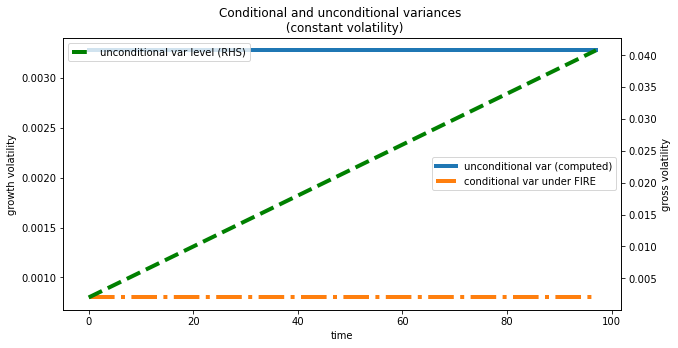

In [196]:
## simulated and computed unconditional variances of first difference 

fig,ax = plt.subplots(figsize=(10,5))
ax.set_title('Conditional and unconditional variances \n (constant volatility)')
ax.plot(np.diag(com_moms_cvol['VarDiff'])[1:],
         '-',
         lw =4,
         label='unconditional var (computed)')
#ax.plot(np.diag(sim_moms_cvol['VarDiff'])[1:],
#         '-*',
#         lw =4,
#         label='unconditional var (simulated)')
ax.plot(com_moms_cvol['VarDiff_fire'][2:],
         '-.',
         lw =4,
         label='conditional var under FIRE')
ax.legend(loc=0)
ax.set_xlabel('time')
ax.set_ylabel('growth volatility')

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(com_moms_cvol['Var'][1:],
         'g--',
         lw= 4,
        label='unconditional var level (RHS)')
ax2.legend(loc=2)
ax2.set_ylabel("gross volatility")

In [197]:
## ma(1) with martingale time-variant volatility 

p_sigmas_draw = p_sigma_cons+np.random.randn(t) ## allowing for time-variant shocks but martingale 
t_sigmas_draw = t_sigma_cons+np.random.randn(t)

sigmas = np.array([p_sigmas_draw,
                   t_sigmas_draw])

dt = IMAProcess(t = t,
                ma_q = 1,
                ϕ = - 0.3) ## ϕ is not equal to zero 
dt.sigmas = sigmas
dt.n_agg = 4  ## quarterly by default 

sim_data_ma1 = dt.SimulateSeries(n_sim = 800)
sim_moms_ma1 = dt.SimulatedMoments()
com_moms_ma1 = dt.ComputeGenMoments()
sim_data_ag_ma1 = dt.TimeAggregate()
sim_moms_ag_ma1 = dt.SimulateMomentsAgg()
com_moms_ag_ma1 = dt.ComputeMomentsAggConsVol()

Text(0, 0.5, 'gross volatility')

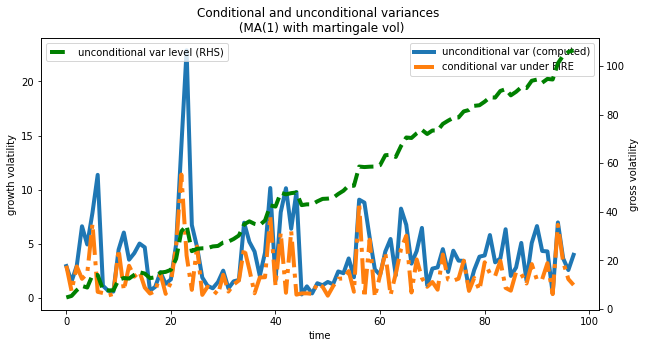

In [198]:
## simulated and computed unconditional variances of first difference 

fig,ax = plt.subplots(figsize=(10,5))
ax.set_title('Conditional and unconditional variances \n (MA(1) with martingale vol)')
ax.plot(np.diag(com_moms_ma1['VarDiff'])[1:],
         '-',
         lw =4,
         label='unconditional var (computed)')
#ax.plot(np.diag(sim_moms_ma1['VarDiff'])[1:],
#         '-*',
#         lw =4,
#         label='unconditional var (simulated)')
ax.plot(com_moms_ma1['VarDiff_fire'][2:],
         '-.',
         lw =4,
         label='conditional var under FIRE')
ax.legend(loc=0)
ax.set_xlabel('time')
ax.set_ylabel('growth volatility')

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(com_moms_ma1['Var'][1:],
         'g--',
         lw= 4,
        label='unconditional var level (RHS)')
ax2.legend(loc=2)
ax2.set_ylabel("gross volatility")

Text(0, 0.5, 'Conditional var under FIRE')

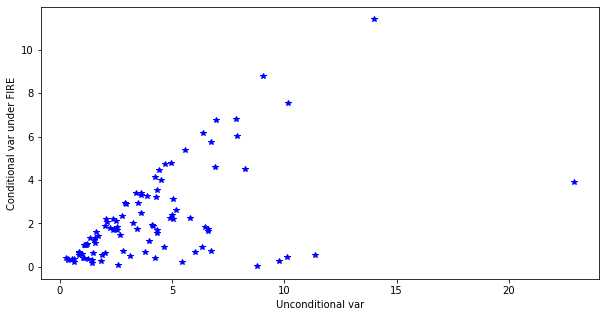

In [199]:
fig = plt.figure(figsize=(10,5))

plt.plot(np.diag(com_moms_ma1['VarDiff'])[1:],
         com_moms_ma1['VarDiff_fire'][2:],
        'b*')
#plt.plot(com_moms_ma1['Var'][1:],
#         com_moms_ma1['VarDiff_fire'][2:],
#        'ro')
plt.xlabel('Unconditional var')
plt.ylabel('Conditional var under FIRE')

Text(0, 0.5, 'gross volatility')

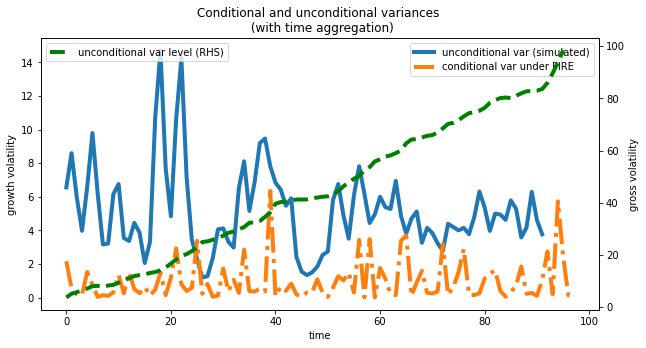

In [200]:
## simulated and computed unconditional variances of first difference 

fig,ax = plt.subplots(figsize=(10,5))
ax.set_title('Conditional and unconditional variances \n (with time aggregation)')
ax.plot(np.diag(sim_moms_ag_ma1['VarDiff'])[1:],
         '-',
         lw =4,
         label='unconditional var (simulated)')
#ax.plot(com_moms_ag_ma1['VarDiff'][1:], ## not working for now 
#         '-*',
#         lw =4,
#         label='unconditional var (computed)')
ax.plot(com_moms_ag_ma1['VarDiff_fire'][2:],
         '-.',
         lw =4,
         label='conditional var under FIRE')
ax.legend(loc=0)
ax.set_xlabel('time')
ax.set_ylabel('growth volatility')

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(np.diag(sim_moms_ag_ma1['Var'])[1:],
         'g--',
         lw= 4,
        label='unconditional var level (RHS)')
ax2.legend(loc=2)
ax2.set_ylabel("gross volatility")

In [205]:
np.diag(sim_moms_ag_ma1['VarDiff']).shape

(93,)

In [210]:
np.corrcoef(np.diag(sim_moms_ag_ma1['VarDiff'])[1:],
            com_moms_ag_ma1['VarDiff_fire'][8:])

array([[ 1.        , -0.12286984],
       [-0.12286984,  1.        ]])

Text(0, 0.5, 'Conditional var under FIRE')

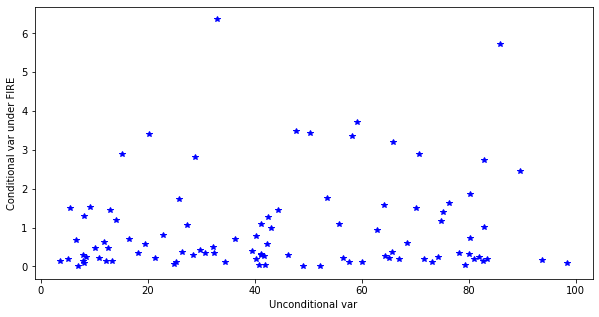

In [178]:
fig = plt.figure(figsize=(10,5))

plt.plot(np.diag(sim_moms_ag_ma1['Var'])[1:],
         com_moms_ag_ma1['VarDiff_fire'][dt.n_agg:],
        'b*')
#plt.plot(com_moms_ma1['Var'][1:],
#         com_moms_ma1['VarDiff_fire'][2:],
#        'ro')
plt.xlabel('Unconditional var')
plt.ylabel('Conditional var under FIRE')

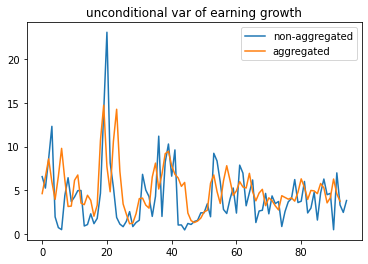

In [211]:
## non aggregated and aggregated variance of first difference 
plt.title('unconditional var of earning growth')
plt.plot(np.diag(sim_moms_ma1['VarDiff'])[dt.n_agg:],
         label='non-aggregated')
plt.plot(np.diag(sim_moms_ag_ma1['VarDiff']),
                 label='aggregated')
plt.legend(loc=0)

In [212]:
## ma(1) with martingale time-variant volatility 

dt_ma0 = IMAProcess(t = t,
                    ma_q = 0, ## crutial difference frm dt
                    ϕ = - 0.8)
dt_ma0.sigmas = sigmas
dt_ma0.n_agg = 4  ## quarterly by default 

sim_data_ma0 = dt_ma0.SimulateSeries(n_sim = 800)
sim_moms_ma0 = dt_ma0.SimulatedMoments()
com_moms_ma0 = dt_ma0.ComputeGenMoments()
sim_data_ag_ma0 = dt_ma0.TimeAggregate()
sim_moms_ag_ma0 = dt_ma0.SimulateMomentsAgg()
com_moms_ag_ma0 = dt_ma0.ComputeMomentsAggConsVol()

Text(0, 0.5, 'gross volatility')

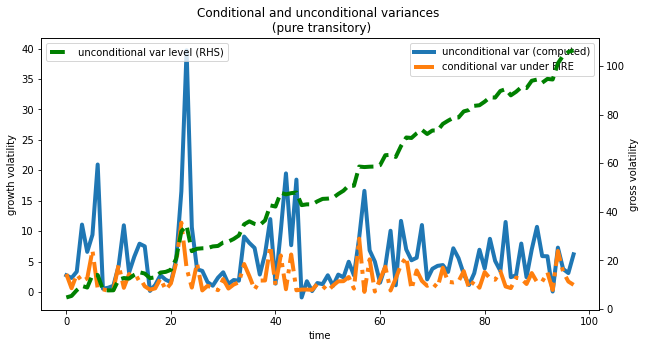

In [213]:
## simulated and computed unconditional variances of first difference 

fig,ax = plt.subplots(figsize=(10,5))
ax.set_title('Conditional and unconditional variances \n (pure transitory)')
ax.plot(np.diag(com_moms_ma0['VarDiff'])[1:],
         '-',
         lw =4,
         label='unconditional var (computed)')
#ax.plot(np.diag(sim_moms_ma1['VarDiff'])[1:],
#         '-*',
#         lw =4,
#         label='unconditional var (simulated)')
ax.plot(com_moms_ma0['VarDiff_fire'][2:],
         '-.',
         lw =4,
         label='conditional var under FIRE')
ax.legend(loc=0)
ax.set_xlabel('time')
ax.set_ylabel('growth volatility')

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(com_moms_ma0['Var'][1:],
         'g--',
         lw= 4,
        label='unconditional var level (RHS)')
ax2.legend(loc=2)
ax2.set_ylabel("gross volatility")

In [54]:
## invoke an instance 

dt_ma0 = IMAProcess(t = t,
                    ma_q = 0,
                    ϕ = 0.0)
dt_ma0.sigmas = sigmas 
dt_ma0.n_agg = 4

sim_data_ma0= dt_ma0.SimulateSeries(n_sim = 800)
sim_moms_ma0 = dt_ma0.SimulatedMoments()
com_com_ag_ma0 = dt_ma0.ComputeMomentsAggConsVol()

In [55]:
com_com_ag_ma0[0,0]

0.726196877577761

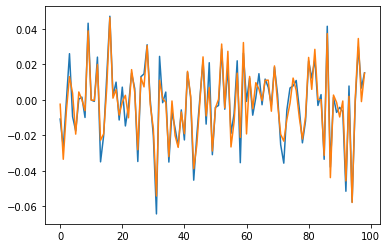

In [51]:
plt.plot(sim_moms_ma1['Mean'])
plt.plot(sim_moms_ma0['Mean'])

In [34]:
## time aggregation 
#dt_fake.n_agg = 12

#dt_fake.TimeAggregate()
#moms_fake_agg = dt_fake.SimulateMomentsAgg()

## and prepare fake data 

#sigmas2 = sigmas*2 
#dt_fake2 = IMAProcess(t = t,
#                      ma_coeffs = ma_nosa)
#dt_fake2.sigmas = sigmas2
#data_fake2= dt_fake2.SimulateSeries(n_sim = 5000)
#moms_fake2 = dt_fake2.SimulatedMoments()
#dt_fake2.n_agg = 3
#dt_fake2.TimeAggregate()
#moms_fake_agg2 = dt_fake2.SimulateMomentsAgg()

In [37]:
# simulated time aggregated moments 
#agg_moms_sim = moms_fake_agg['Var']

# computed time aggregated moments 
#agg_moms_com = dt_fake.ComputeMomentsAgg()

#distance = np.linalg.norm((agg_moms_com[3:,3:] - agg_moms_sim))

In [38]:
#distance

In [39]:
## estimation 
#dt_fake.GetDataMomentsAgg(moms_fake_agg2)
#dt_fake.EstimateParaAggCompute()

## Estimate volatility 

In [40]:
## simulate volatility 

dt.SimulateSVols()
dt.SimulateSVolsAgg()
dt.SimulateSVolsAggMoms()

dt_fake.SimulateSVols()
dt_fake.SimulateSVolsAgg()
svols_fake = dt_fake.SimulateSVolsAggMoms()

In [41]:
#plt.plot(dt.vols_agg_sim_moms['ATV'])

In [42]:
#dt.GetDataMomentsVolsAgg(svols_fake)
#dt.EstimateSVolsParaAgg()

Optimization terminated successfully.
         Current function value: 0.000129
         Iterations: 84
         Function evaluations: 151


array([0.49999941, 0.00099911, 0.00833814])

In [43]:
## after estimation 
#dt.rho,dt.gamma, dt.sigma_eps = dt.para_svols_est_agg
#vols_sim = dt.SimulateSVols()
#vols_agg_sim = dt.SimulateSVolsAgg()
#vols_agg_sim_mom = dt.SimulateSVolsAggMoms()

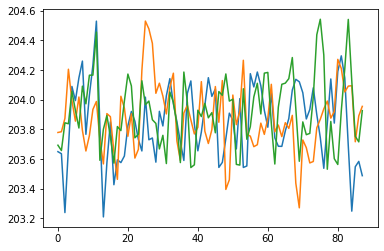

In [47]:
## permanent and transitory 
#plt.plot(vols_agg_sim[0:3,12:].T)

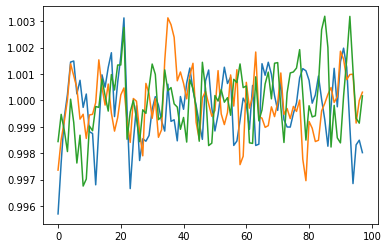

In [48]:
#plt.plot(vols_sim[0:3,12:].T)

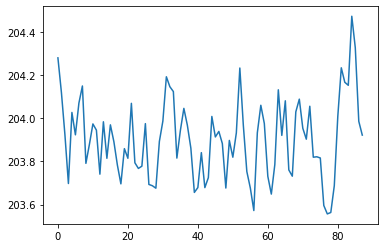

In [73]:
#plt.plot(vols_agg_sim_mom['Mean'][12:])